In [698]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import locale
import geobr

%matplotlib inline
sns.set_style("darkgrid")

# Data Cleaning

In [699]:
raw_data = pd.read_csv('full_data/data_PR.csv')

In [700]:
raw_data.head()

,CNPJ_BASICO,CNPJ_ORDEM,IDENTIFICADOR_MATRIZ/FILIAL,NOME_FANTASIA,SITUACAO_CADASTRAL,DATA_SITUACAO_CADASTRAL,DATA_DE_INICIO_ATIVIDADE,CNAE_FISCAL_PRINCIPAL,UF,MUNICIPIO,CORREIO_ELETRONICO,NATUREZA_JURIDICA,CAPITAL_SOCIAL_DA_EMPRESA,PORTE_DA_EMPRESA
0,30139956,1,1,MACIEL ENGENHARIA,8,20180716,20180408,5819100,PR,7535,jurodriguesm@gmail.com,2135,"100,00",1.0
1,30140063,1,1,PETPOA,2,20180409,20180409,1412602,PR,7535,palaoroangelamaria@gmail.com,2135,"2000,00",1.0
2,30140189,1,1,NaN,2,20180322,20180322,6911701,PR,7691,NaN,2232,"10000,00",5.0
3,30140471,1,1,VILELA PRESTACAO DE SERVICO,2,20180409,20180409,3329501,PR,7749,tv3829485@gmail.com,2135,"1000,00",1.0
4,30140494,1,1,JG CONSTRUCOES,2,20180409,20180409,4399103,PR,5453,NaN,2135,"1,00",1.0


In [701]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3749552 entries, 0 to 3749551
Data columns (total 14 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   CNPJ_BASICO                  int64  
 1   CNPJ_ORDEM                   int64  
 2   IDENTIFICADOR_MATRIZ/FILIAL  int64  
 3   NOME_FANTASIA                object 
 4   SITUACAO_CADASTRAL           int64  
 5   DATA_SITUACAO_CADASTRAL      int64  
 6   DATA_DE_INICIO_ATIVIDADE     int64  
 7   CNAE_FISCAL_PRINCIPAL        int64  
 8   UF                           object 
 9   MUNICIPIO                    int64  
 10  CORREIO_ELETRONICO           object 
 11  NATUREZA_JURIDICA            int64  
 12  CAPITAL_SOCIAL_DA_EMPRESA    object 
 13  PORTE_DA_EMPRESA             float64
dtypes: float64(1), int64(9), object(4)
memory usage: 400.5+ MB


In [702]:
#Change social share type from str to float (the issue arises due to a difference between Portuguese and English on the use of commas and dots to separate decimal places)
raw_data['CAPITAL_SOCIAL_DA_EMPRESA']=raw_data['CAPITAL_SOCIAL_DA_EMPRESA'].str.replace(',','.').astype(float)

In [703]:
#Format the status and creation date to datetime. Due to some inconsistencies, some status dates were 0 (don't exist), in those cases we copy the creation date.
mask = raw_data['DATA_SITUACAO_CADASTRAL']==0
raw_data.loc[mask, 'DATA_SITUACAO_CADASTRAL'] = raw_data.loc[mask, 'DATA_DE_INICIO_ATIVIDADE']
raw_data['DATA_SITUACAO_CADASTRAL']=pd.to_datetime(raw_data['DATA_SITUACAO_CADASTRAL'], format='%Y%m%d')
raw_data['DATA_DE_INICIO_ATIVIDADE']=pd.to_datetime(raw_data['DATA_DE_INICIO_ATIVIDADE'], format='%Y%m%d')

In [704]:
#Scrap data from government website to get the town (municipio) name based on the town's code
#The data is also available in the full_data folder (municipio_code.csv)
mun_name = pd.read_html('http://www.fazenda.mg.gov.br/governo/assuntos_municipais/codigomunicipio/codmunicoutest_pr.html')[0]
mun_name.columns= ['town_name','CODE_SEF-MG','MUNICIPIO']
mun_name = mun_name.iloc[3:].dropna()
mun_name['MUNICIPIO'] = mun_name['MUNICIPIO'].astype(int)

In [705]:
#Merges raw_data and mun_name to get the town's name based on the town's code.
raw_data = raw_data.merge(mun_name.iloc[3:][['town_name','MUNICIPIO']], on='MUNICIPIO',how='left')

In [706]:
#Email provider from email
raw_data['email_provider']=raw_data.CORREIO_ELETRONICO.str.lower().str.extract(r'\@(\w+)\.')

In [707]:
#Company size. Uses a dictionary to relate the size code to the size description.
dic_porte = {0:np.NaN, 1:'Microbusiness',3:'Small',5:'Other'}
raw_data['PORTE_DA_EMPRESA']=raw_data['PORTE_DA_EMPRESA'].fillna(0).astype(int).map(dic_porte)

In [708]:
#Company legal entity type. Uses a dictionary to relate the legal entity type code to its description. 
#The dictionary considers only the most common entity type that is not a political candidate(4090) and private associations (3999). 
dic_jur = {2135:'Empresário Individual',2062:'Sociedade Empresaria Limitada',2240:'Sociedade Simples Limitada',2054:'Sociedade Anonima Fechada'}
raw_data['NATUREZA_JURIDICA']=raw_data['NATUREZA_JURIDICA'].map(dic_jur).fillna('Other')

In [709]:
#Company status. Uses a dictionary to relate the status code to the status description.
dic_situa = {1:'Not valid',2:'Active',3:'Suspended',4:'Inapt',8:'Defunct'}
raw_data['SITUACAO_CADASTRAL']=raw_data['SITUACAO_CADASTRAL'].map(dic_situa)

In [710]:
#Number of branches in PR state
raw_data['branches_state']=raw_data.groupby('CNPJ_BASICO').CNPJ_BASICO.transform('count')

In [711]:
#Changes the headquarters/branch identification to a binary yes/no form 1 (headquarters) and 0 (branch)
raw_data['IDENTIFICADOR_MATRIZ/FILIAL']=raw_data['IDENTIFICADOR_MATRIZ/FILIAL'].apply(lambda x: 0 if x==2 else x)

In [712]:
#cnae is a 7 number that defines the economical activity. It is structured in such a way that the first 2 numbers (and it might be a left zero!) define 21 economical activity classes
##See the website in portuguese for more information https://blog.contaazul.com/cnae-o-que-e-confira-tabela/
#To simplify, I divide the 21 classes into 3 major economical sectors (Agriculture, Industry and Service), here we simplify that service is everything that is not agriculture and industry (oversimplification!) 
def economy_sector(x):
    if x in range(1,4): 
        return 'Agriculture';
    elif x in range(5,34): 
        return 'Industry';
    else: 
        return 'Service'; 

In [713]:
#Get the digits associated with the cnae class and apply the economy_sector function to get the economical sector
raw_data['cnae_class']=raw_data['CNAE_FISCAL_PRINCIPAL'].astype(str).str.extract(r'(\d+)\d{5}').astype(int)
raw_data['economic_sector']=raw_data['cnae_class'].apply(lambda x: economy_sector(x))

In [714]:
#Drop and rename columns
droplist = ['NOME_FANTASIA','CNAE_FISCAL_PRINCIPAL','UF','MUNICIPIO','CORREIO_ELETRONICO','cnae_class']
rename_cols = {'SITUACAO_CADASTRAL':'company_status','NATUREZA_JURIDICA':'entity_type','PORTE_DA_EMPRESA':'company_size','IDENTIFICADOR_MATRIZ/FILIAL':'headquarters',
               'DATA_SITUACAO_CADASTRAL':'company_status_date','DATA_DE_INICIO_ATIVIDADE':'company_start_date','CAPITAL_SOCIAL_DA_EMPRESA':'share_capital','CNPJ_BASICO':'base_cnpj','CNPJ_ORDEM':'branch_number'}
raw_data=raw_data.rename(columns=rename_cols).drop(droplist,axis=1)

In [715]:
#To facilitate the data analysis, reorder the columns and use a new variable clean_data
reorder = ['base_cnpj','company_start_date','company_status','company_status_date','town_name','economic_sector','entity_type','share_capital','company_size','headquarters','branch_number','branches_state','email_provider']
clean_data=raw_data[reorder]

In [716]:
clean_data.head()

,base_cnpj,company_start_date,company_status,company_status_date,town_name,economic_sector,entity_type,share_capital,company_size,headquarters,branch_number,branches_state,email_provider
0,30139956,2018-04-08,Defunct,2018-07-16,CURITIBA,Service,Empresário Individual,100.0,Microbusiness,1,1,1,gmail
1,30140063,2018-04-09,Active,2018-04-09,CURITIBA,Industry,Empresário Individual,2000.0,Microbusiness,1,1,1,gmail
2,30140189,2018-03-22,Active,2018-03-22,MARINGA,Service,Other,10000.0,Other,1,1,1,NaN
3,30140471,2018-04-09,Active,2018-04-09,PARANAVAI,Industry,Empresário Individual,1000.0,Microbusiness,1,1,1,gmail
4,30140494,2018-04-09,Active,2018-04-09,PINHAIS,Service,Empresário Individual,1.0,Microbusiness,1,1,1,NaN


# EDA Section

Before we start, we need to check our data for any possible issue that might interfere with the data analysis. One possible issue is that we have incomplete data for one of the years. To verify it, we can see the minimum and maximum dates for 'company_start_date' and 'company_status_date':

In [717]:
print('Start date range: ',clean_data['company_start_date'].min(),'-',clean_data['company_start_date'].max())
print('Status date range: ',clean_data['company_status_date'].min(),'-',clean_data['company_status_date'].max())

Start date range:  1901-01-01 00:00:00 - 2023-03-11 00:00:00
Status date range:  1901-01-01 00:00:00 - 2023-03-11 00:00:00


As expected, the data ends in March 2023. When we consider any data analysis that needs to count values, we might need to factor it.

Below, we will analyze how the number of newly created companies changes over the years, but also over the months (does it have any seasonality?) and even over the week. This should give us a general picture of the company creation dynamics in PR state. Now, we create columns with the year, month and day, which will simplify our analysis.

In [718]:
#We can create new columns with year, month and day of the creation date
clean_data['company_start_year']=clean_data['company_start_date'].dt.strftime('%Y').astype(int)
clean_data['company_start_month']=clean_data['company_start_date'].dt.strftime('%B')
clean_data['company_start_day']=clean_data['company_start_date'].dt.strftime('%A')
clean_data['company_status_year']=clean_data['company_status_date'].dt.strftime('%Y').astype(int)

C:\Users\rapha\AppData\Local\Temp\ipykernel_19076\1913725239.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data['company_start_year']=clean_data['company_start_date'].dt.strftime('%Y').astype(int)
C:\Users\rapha\AppData\Local\Temp\ipykernel_19076\1913725239.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data['company_start_month']=clean_data['company_start_date'].dt.strftime('%B')
C:\Users\rapha\AppData\Local\Temp\ipykernel_19076\1913725239.py:4: SettingWithCopyWarning: 
A value is tr

One of the most important plots to understand the dynamics of company creation is the number of new companies by year. To make it easier to understand different contributions, we separate the data into the economic sectors and we also plot the year-by-year difference, i.e. the number of newly created companies in the current year minus the number of created companies in the previous year.

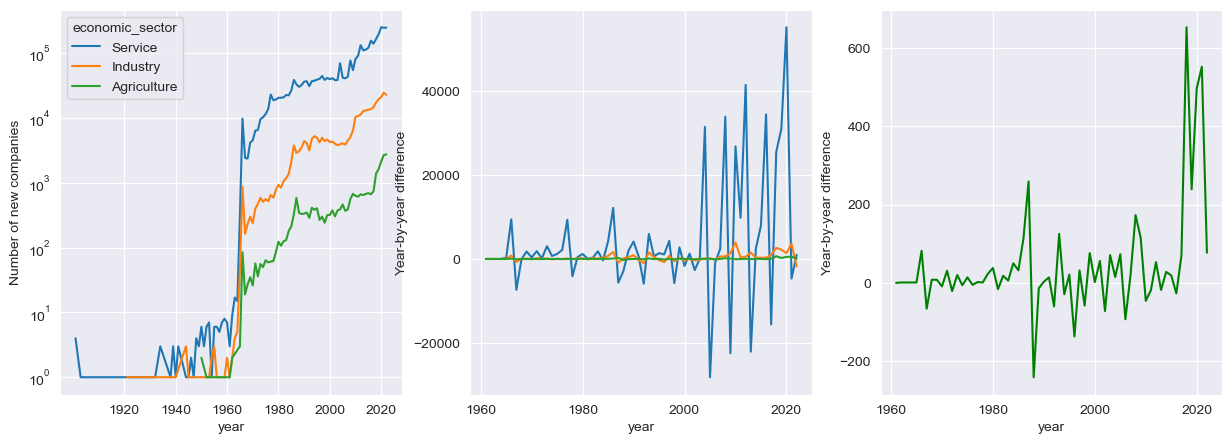

In [719]:
diff_data=(clean_data[clean_data['company_start_year']<2023]
.groupby(clean_data['economic_sector'])['company_start_year']
.value_counts()
.rename('new_companies')
.reset_index()
.sort_values(by=['economic_sector','company_start_year']))
diff_data['diff']=diff_data.new_companies.diff();

fig, axes = plt.subplots(1, 3, figsize=(15,5))

sns.lineplot(data=diff_data, x='company_start_year',y='new_companies',hue='economic_sector',hue_order=['Service','Industry','Agriculture'],ax=axes[0])
axes[0].set(yscale='log')
axes[0].set(xticks=np.arange(1920,2030,20))
axes[0].set_ylabel("Number of new companies")

sns.lineplot(data=diff_data[diff_data['company_start_year']>1960], x='company_start_year',y='diff',hue='economic_sector',hue_order=['Service','Industry','Agriculture'],ax=axes[1])
axes[1].set(xticks=np.arange(1960,2030,20))
axes[1].get_legend().remove()
axes[1].set_ylabel("Year-by-year difference")

sns.lineplot(data=diff_data[(diff_data['company_start_year']>1960) & (diff_data['economic_sector']=='Agriculture')], x='company_start_year',y='diff',ax=axes[2],color='green')
axes[2].set(xticks=np.arange(1960,2030,20))
axes[2].set_ylabel("Year-by-year difference")

for x in range(3):
    axes[x].set_xlabel("year")


In the left plot, we can observe three important features. The first is that the data is meaningful after the 1960s, so we should concentrate our analysis from the 1960s to 2022. The second feature is that service has about 10 times more companies being created than the industry, which in turn, has the same relation to agriculture. The third feature is that all economic sectors have more or less the same dynamics. A growth that starts in the 1960s, slows down between the 1980s and 2000s and speeds up afterwards. 

In the central plot, we can see some general trends in the year-by-year difference. When we have a very large increase in new companies the next year it tends to decrease (even if slightly). Another important feature is that starting in the 2000s we see a very large increase in the absolute value of year-by-year difference. This is associated with a new law (MEI) and its updates that allowed people to create microbusinesses with less bureaucracy and allowed them to be employed as contractors instead of workers. 

The third plot shows only the agriculture sector. As expected we don't see the same variations in the service sector since the MEI law is more common in the service sector. 

The exponential increase in new companies could give a false impression that the economy is growing, which is not necessarily correct (note that even during covid the trend continues). We can look into the number of companies that cease to be active.

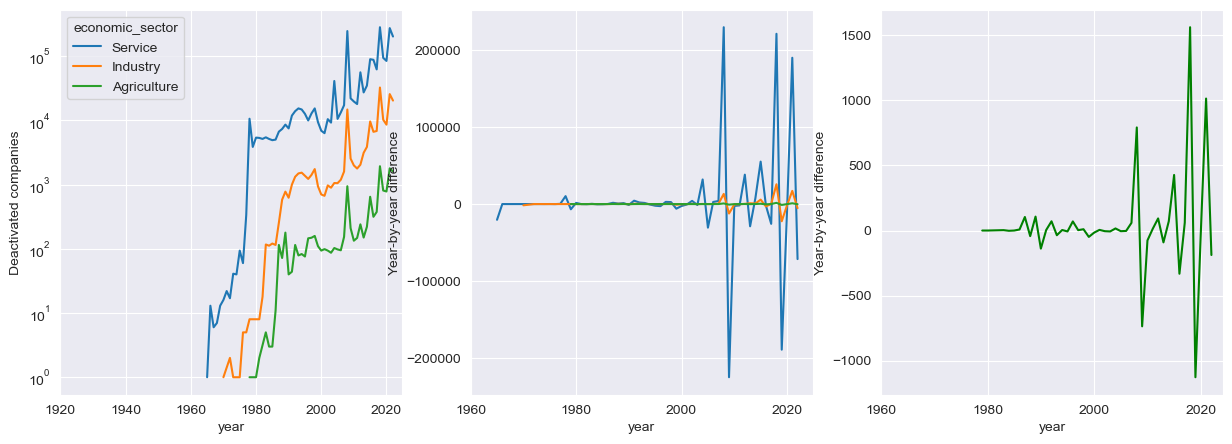

In [720]:
diff_data_de=(clean_data[(clean_data['company_status_year']<2023) & (clean_data['company_status']!='Active')]
.groupby(clean_data['economic_sector'])['company_status_year']
.value_counts()
.rename('not_active_companies')
.reset_index()
.sort_values(by=['economic_sector','company_status_year']))
diff_data_de['diff']=diff_data_de.not_active_companies.diff();

fig, axes = plt.subplots(1, 3, figsize=(15,5))

sns.lineplot(data=diff_data_de, x='company_status_year',y='not_active_companies',hue='economic_sector',hue_order=['Service','Industry','Agriculture'],ax=axes[0])
axes[0].set(yscale='log')
axes[0].set(xticks=np.arange(1920,2030,20))
axes[0].set_ylabel("Deactivated companies")

sns.lineplot(data=diff_data_de[diff_data_de['company_status_year']>1960], x='company_status_year',y='diff',hue='economic_sector',hue_order=['Service','Industry','Agriculture'],ax=axes[1])
axes[1].set(xticks=np.arange(1960,2030,20))
axes[1].get_legend().remove()
axes[1].set_ylabel("Year-by-year difference")

sns.lineplot(data=diff_data_de[(diff_data_de['company_status_year']>1960) & (diff_data_de['economic_sector']=='Agriculture')], x='company_status_year',y='diff',ax=axes[2],color='green')
axes[2].set(xticks=np.arange(1960,2030,20))
axes[2].set_ylabel("Year-by-year difference")

for x in range(3):
    axes[x].set_xlabel("year")

In the left plot, we see that the number of companies that cease to be active grows exponentially each year, starting around the 2000s, showing that many of the new companies might not last long (more about it later). Overall we see the same properties in the year-by-year difference seen in the new companies' plots.

For economic analysis, the net companies (number of new companies minus the number of companies that ceased to be active in a year) can be used as a proxy to see how the economy is faring

In [721]:
diff_data=diff_data.merge(diff_data_de, how='left', left_on=['economic_sector','company_start_year'],right_on=['economic_sector','company_status_year']).fillna(0)
diff_data['net_companies']=diff_data.apply(lambda x: x['new_companies']-x['not_active_companies'],axis=1)

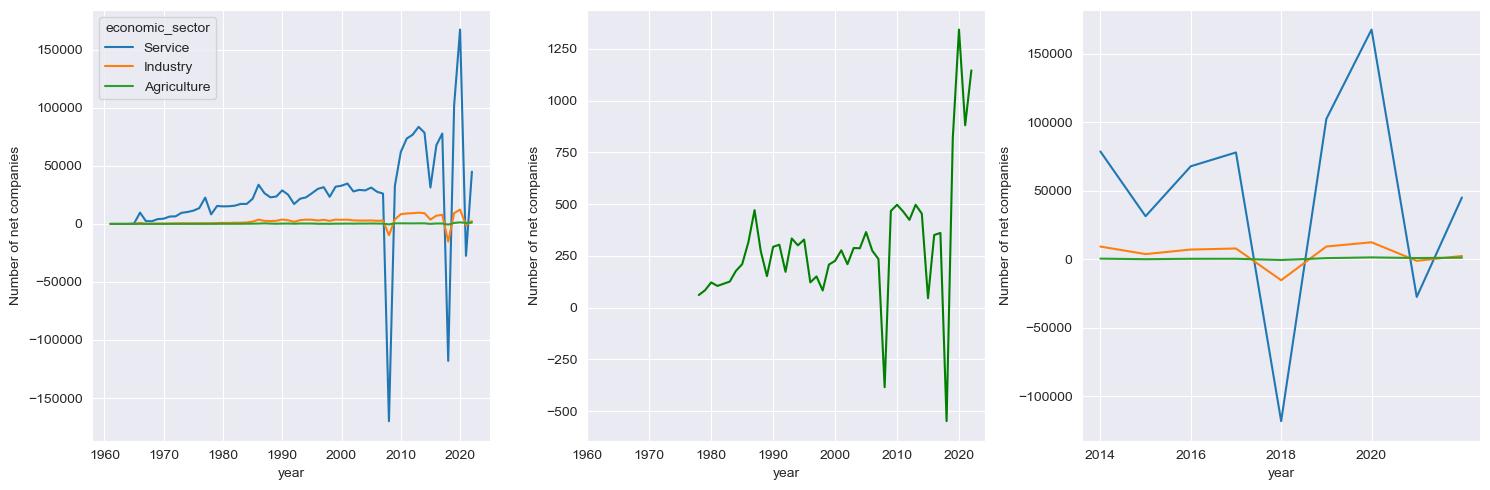

In [754]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))

sns.lineplot(data=diff_data[diff_data['company_start_year']>1960], x='company_start_year',y='net_companies',hue='economic_sector',hue_order=['Service','Industry','Agriculture'],ax=axes[0])
#axes.set(yscale='log')
axes[0].set(xticks=np.arange(1960,2030,10))
axes[0].set_ylabel("Number of net companies")
axes[0].set_xlabel("year")

sns.lineplot(data=diff_data[(diff_data['company_status_year']>1960) & (diff_data['economic_sector']=='Agriculture')], x='company_status_year',y='net_companies',ax=axes[1],color='green')
#axes.set(yscale='log')
axes[1].set(xticks=np.arange(1960,2030,10))
axes[1].set_ylabel("Number of net companies")
axes[1].set_xlabel("year")

sns.lineplot(data=diff_data[diff_data['company_start_year']>2013], x='company_start_year',y='net_companies',hue='economic_sector',hue_order=['Service','Industry','Agriculture'],ax=axes[2])
#axes.set(yscale='log')
axes[2].set(xticks=np.arange(2014,2022,2))
axes[2].set_ylabel("Number of net companies")
axes[2].set_xlabel("year")
axes[2].get_legend().remove()
plt.tight_layout()

All three plots show the number of net companies added by year. The left plot shows the net companies for all economic sectors, we can see 3 dates in which the net number is negative for the service sector. These three years are associated with the economic crisis. The central plot shows the net companies in the agriculture sector, although the covid pandemic (2021) affects the net number of new agriculture companies, it doesn't affect as much as one might have believed. The third plot focuses on the period 2014-2022. 

We can go back to the creation of new companies, and we can ask the question if these are really new companies or a new branch office.

C:\Users\rapha\AppData\Local\Temp\ipykernel_19076\112208983.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newstate['HeadquarterState']=clean_data.groupby('base_cnpj')['headquarters'].transform(max)


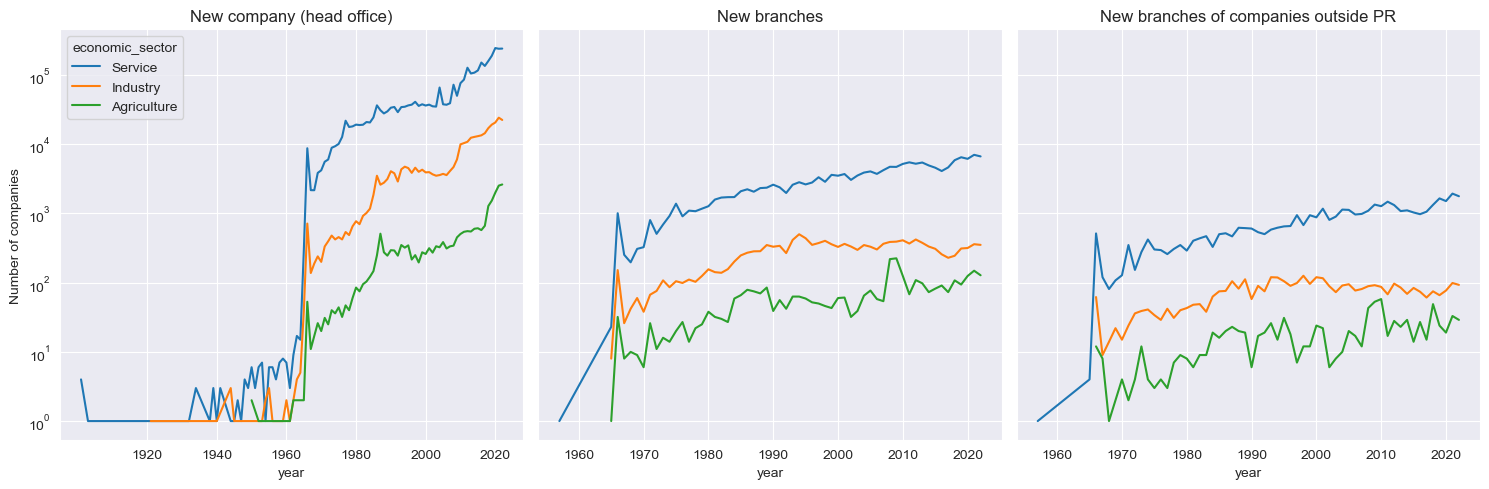

In [723]:
#detail Trends of: companies with other branches opening in the state (first time), companies in the state opening more branches, new companies
fig, axes = plt.subplots(1,3, figsize=(15,5),sharey=True)

(clean_data[(clean_data['headquarters']==1) & (clean_data['company_start_year']<2023)][['company_start_year','economic_sector']]
.value_counts()
.rename('new_companies')
.reset_index()
.sort_values(by='company_start_year')
.pipe((sns.lineplot,'data'), x='company_start_year',y='new_companies',ax=axes[0],hue='economic_sector',hue_order=['Service','Industry','Agriculture']))
axes[0].set(yscale='log')
axes[0].set(xticks=np.arange(1920,2030,20))
axes[0].set_title("New company (head office)")

(clean_data[(clean_data['headquarters']==0) & (clean_data['company_start_year']<2023)][['company_start_year','economic_sector']]
.value_counts()
.rename('new_companies')
.reset_index()
.sort_values(by='company_start_year')
.pipe((sns.lineplot,'data'), x='company_start_year',y='new_companies',ax=axes[1],hue='economic_sector',hue_order=['Service','Industry','Agriculture']))
axes[1].set(yscale='log')
axes[1].get_legend().remove()
axes[1].set_title("New branches")

newstate=clean_data[['base_cnpj','company_start_year','economic_sector']]
newstate['HeadquarterState']=clean_data.groupby('base_cnpj')['headquarters'].transform(max)
(newstate[(newstate['HeadquarterState']==0) & (clean_data['company_start_year']<2023)][['company_start_year','economic_sector']]
.value_counts()
.rename('new_companies')
.reset_index()
.sort_values(by='company_start_year')
.pipe((sns.lineplot,'data'), x='company_start_year',y='new_companies',hue='economic_sector',ax=axes[2],hue_order=['Service','Industry','Agriculture']))
axes[2].get_legend().remove()
axes[2].set_title("New branches of companies outside PR")
axes[2].set(yscale='log')

for x in range(3):
    axes[x].set_xlabel("year")
    axes[x].set_ylabel("Number of companies")

plt.tight_layout()

Interestingly enough, we see most of the companies are new (headquarters). New branch offices grow as polynomials instead of exponentials and most of them are from companies already in PR state. Companies arriving from outside PR state usually open about 10% of the branch offices.

We can also see the composition of new companies by legal entity type

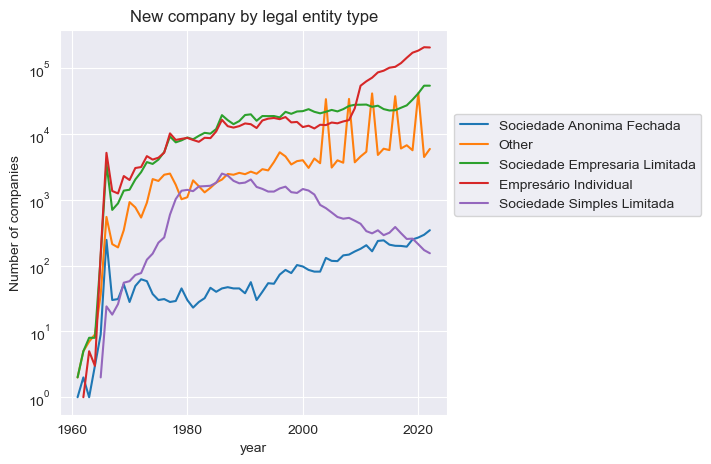

In [755]:
fig, axes = plt.subplots(figsize=(5,5))

(clean_data[(clean_data['headquarters']==1) & (clean_data['company_start_year']<2023) & (clean_data['company_start_year']>1960)][['company_start_year','entity_type']]
.value_counts()
.rename('new_companies')
.reset_index()
.sort_values(by='company_start_year')
.pipe((sns.lineplot,'data'), x='company_start_year',y='new_companies',ax=axes,hue='entity_type'))
axes.set(yscale='log')
axes.set(xticks=np.arange(1960,2030,20))
axes.legend(loc='best',bbox_to_anchor=(1., 0.8),ncol=1)
axes.set_xlabel("year")
axes.set_ylabel("Number of companies")
axes.set_title("New company by legal entity type");

The interesting feature in this plot is the jump of "Empresario Individual" around 2008. This is associated with the MEI law that for microbusinesses allowed simplified bureaucracy as well as work as contractors. Recently, some companies started using contractors instead of contracting workers to lower costs. 

Finally, we can see the expected lifetime of new companies based on the time between the creation of a company and when it ceased to be active. Due to some inconsistencies, the status date is less than the creation date, because of this, we need to select only the data in which the creation date is larger than the status date.

In [748]:
clean_data['time_to_deact']=clean_data[clean_data['company_status']!='Active'].apply(lambda x: x['company_status_year']-x['company_start_year'],axis=1)

C:\Users\rapha\AppData\Local\Temp\ipykernel_19076\2833237901.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data['time_to_deact']=clean_data[clean_data['company_status']!='Active'].apply(lambda x: x['company_status_year']-x['company_start_year'],axis=1);


In [726]:
clean_data['time_to_deact'].min()

-6.0

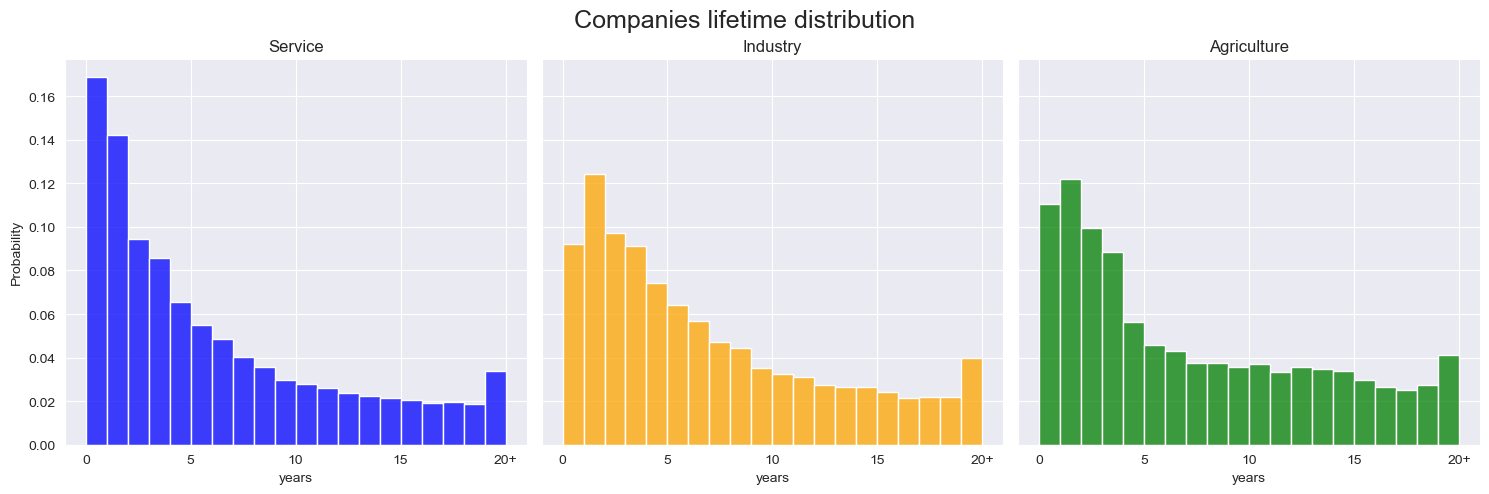

In [727]:
fig, axes = plt.subplots(1,3, figsize=(15,5), sharey=True)

color_hist=['blue','orange','green']
for eco,rang in zip(['Service','Industry','Agriculture'],range(3)):
    sns.histplot(clean_data[(clean_data['economic_sector']==eco) & (clean_data['time_to_deact']>=0)],x='time_to_deact',binwidth=1,binrange=(0,20),stat="probability",ax=axes[rang],color=color_hist[rang])
    axes[rang].set_title(eco)
    axes[rang].set_xlabel('years')
    axes[rang].set(xticks=np.arange(0,21,5))
    axes[rang].set_xticklabels(np.append(np.arange(0,20,5),'20+'))
plt.tight_layout()
plt.suptitle('Companies lifetime distribution',fontsize=18)
fig.subplots_adjust(top=0.88)



In [728]:
clean_data[clean_data['time_to_deact']>=0].groupby('economic_sector')['time_to_deact'].describe()
#Negative values indicate some issue, explore more

,count,mean,std,min,25%,50%,75%,max
economic_sector,,,,,,,,
Agriculture,12808.0,10.437539,9.999391,0.0,2.0,7.0,16.0,56.0
Industry,177049.0,9.456456,9.354061,0.0,2.0,6.0,14.0,74.0
Service,1952343.0,9.100807,9.952844,0.0,1.0,5.0,14.0,87.0


Another important factor in the company's creation is the year seasonality. Due to different phenomena, companies might be more prone to open in specific months

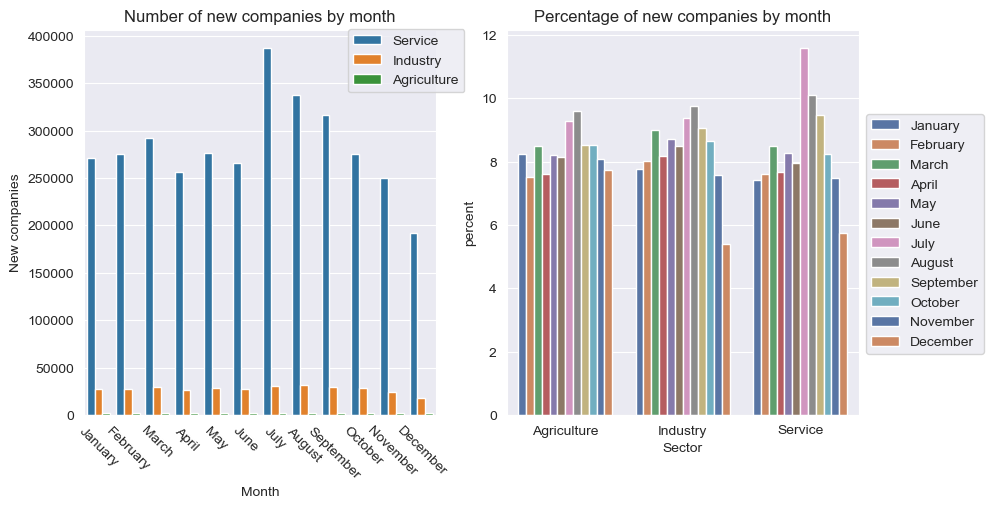

In [749]:
fig, axes = plt.subplots(1,2, figsize=(10,5))

month_order = ['January','February','March','April','May','June','July','August','September','October','November','December']
sns.countplot(data=clean_data,x='company_start_month',order=month_order,
              hue='economic_sector',ax=axes[0])
axes[0].tick_params(axis='x', rotation=-45)
axes[0].set_title("Number of new companies by month")
axes[0].legend(loc='center right', bbox_to_anchor=(1.1, 0.92), ncol=1)
axes[0].set_xlabel('Month')
axes[0].set_ylabel('New companies')
#sns.move_legend("upper left", bbox_to_anchor=(1, 1))

(clean_data[clean_data['company_start_year']<2023]
.groupby(clean_data['economic_sector'])['company_start_month']
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.barplot,'data'), x='economic_sector',y='percent',hue='company_start_month', hue_order=month_order, palette='deep',ax=axes[1]))
axes[1].legend(loc='best', bbox_to_anchor=(1., 0.8), ncol=1)
axes[1].set_title("Percentage of new companies by month")
axes[1].set_xlabel('Sector');
#axes[1].xticks(rotation=-45)

The peak in July for the service sector can be understood in terms when we look at the creation of new companies by legal entity types each month

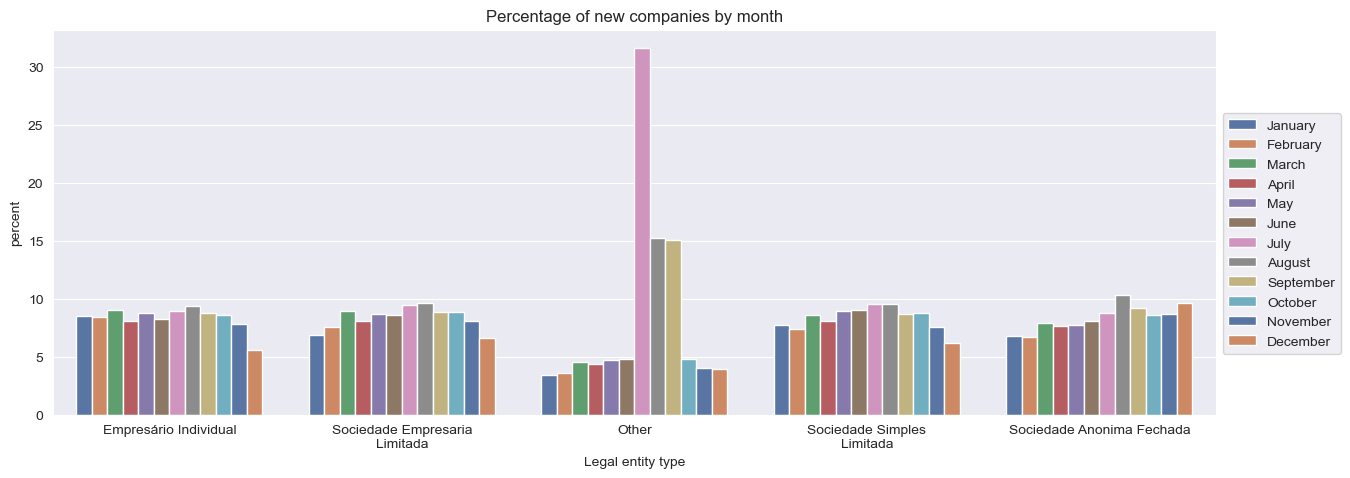

In [759]:
order_entity = ['Empresário Individual', 'Sociedade Empresaria Limitada', 'Other', 'Sociedade Simples Limitada','Sociedade Anonima Fechada']

fig, axes = plt.subplots(figsize=(15,5))

(clean_data[clean_data['company_start_year']<2023]
.groupby(clean_data['entity_type'])['company_start_month']
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.barplot,'data'), x='entity_type',y='percent',hue='company_start_month', hue_order=month_order, palette='deep', order= order_entity))
axes.legend(loc='best', bbox_to_anchor=(1., 0.8), ncol=1)
axes.set_title("Percentage of new companies by month")
axes.set_xlabel('Legal entity type')
axes.set_xticklabels(['Empresário Individual', 'Sociedade Empresaria\nLimitada', 'Other',
       'Sociedade Simples\nLimitada','Sociedade Anonima Fechada']);

The 'Other' legal entity type has different companies, such as political committees, that opens around the same time, this might be one of the reasons for July-peak for other type

As can be seen, the "Other" legal entity type has a significant proportion of all companies, which distorts the first plot

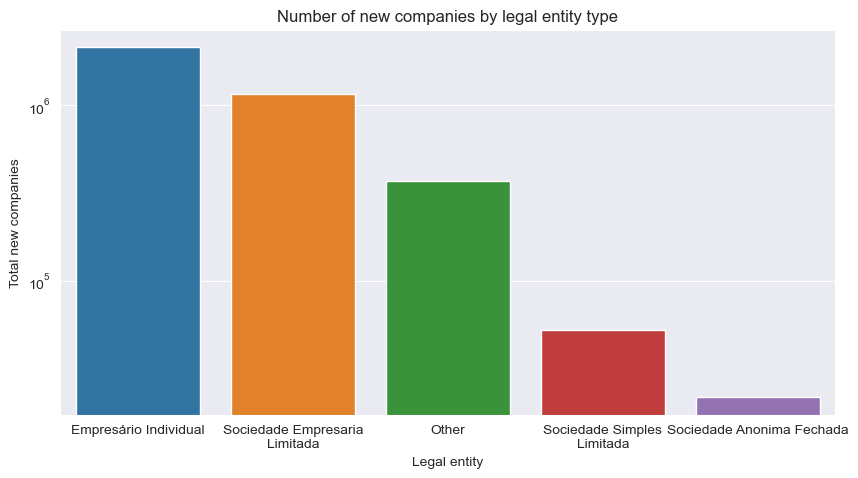

In [760]:
fig, axes = plt.subplots(figsize=(10,5))
order_entity = ['Empresário Individual', 'Sociedade Empresaria Limitada', 'Other', 'Sociedade Simples Limitada','Sociedade Anonima Fechada']
sns.countplot(data=clean_data, x='entity_type',order= order_entity)
axes.set_title("Number of new companies by legal entity type")
axes.set_xlabel('Legal entity')
axes.set(yscale='log')
axes.set_ylabel('Total new companies')
axes.set_xticklabels(['Empresário Individual', 'Sociedade Empresaria\nLimitada', 'Other',
       'Sociedade Simples\nLimitada','Sociedade Anonima Fechada']);

Not only do months have seasonality, but even days of the week do have. We don't expect many companies to open on the weekend, but even during weekdays we see different patterns depending on which economic sector we look at

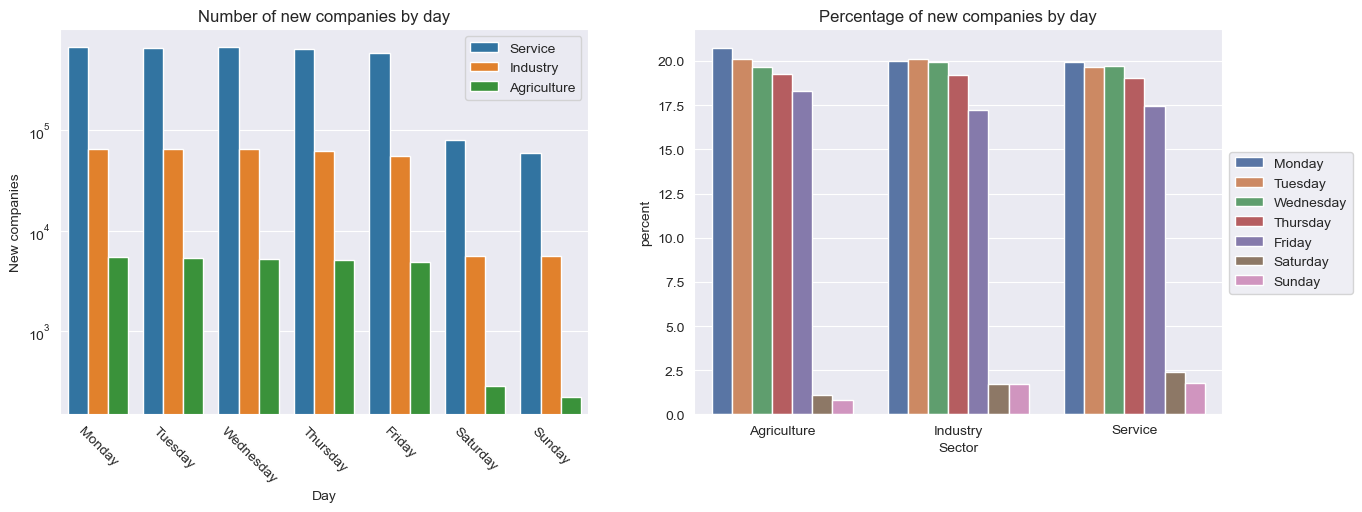

In [745]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
order_days=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

sns.countplot(data=clean_data[clean_data['company_start_year']<2023],x='company_start_day',order=order_days,
             hue='economic_sector',ax=axes[0])
axes[0].tick_params(axis='x', rotation=-45)
axes[0].legend(loc='best', bbox_to_anchor=(1, 1), ncol=1)
axes[0].set_xlabel('Day')
axes[0].set(yscale='log')
axes[0].set_ylabel('New companies')
axes[0].set_title("Number of new companies by day")


(clean_data[clean_data['company_start_year']<2023]
.groupby(clean_data['economic_sector'])['company_start_day']
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.barplot,'data'), x='economic_sector',y='percent',hue='company_start_day',hue_order=order_days, palette='deep'))
axes[1].legend(loc='best', bbox_to_anchor=(1., 0.7), ncol=1)
axes[1].set_xlabel('Sector')
axes[1].set_title("Percentage of new companies by day");

With this plot, we conclude the section on new companies. We can now start looking into some of the properties these companies have

The first one is share capital, a self-declared number that states how much money (or assets) the owners are willing to apply at the company. Note that, because it is self-declared, it might not correspond to reality, indeed we see some cases in which the share capital is 0. 

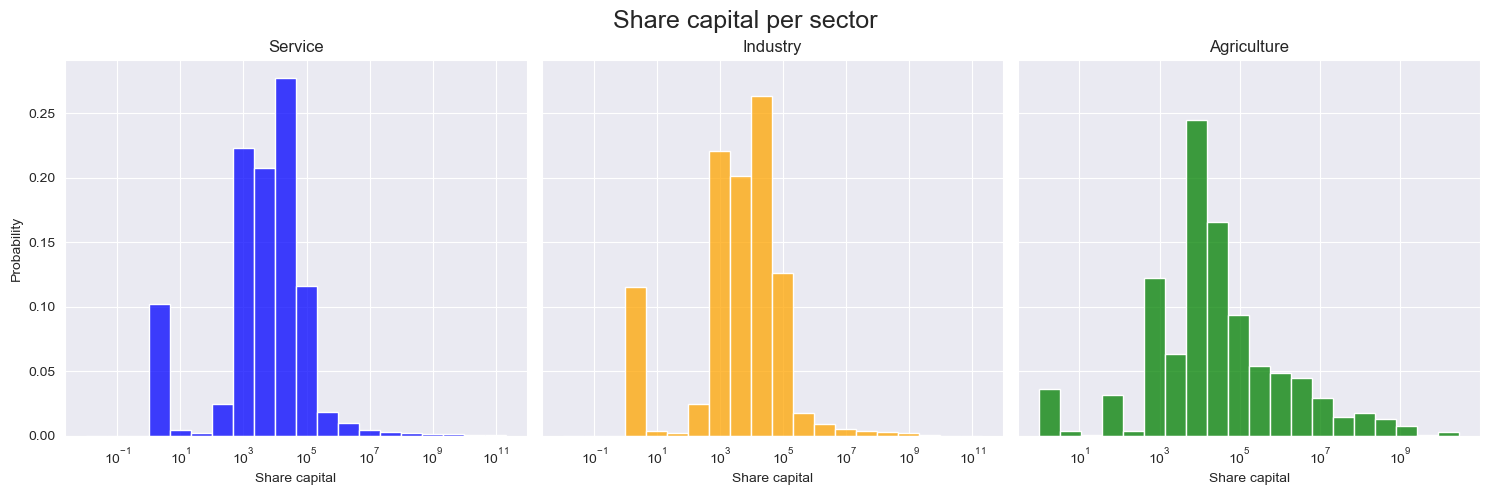

In [733]:
fig, axes = plt.subplots(1,3, figsize=(15,5), sharey=True)

color_hist=['blue','orange','green']
for eco,rang in zip(['Service','Industry','Agriculture'],range(3)):
    sns.histplot(clean_data[(clean_data['share_capital']>0)&(clean_data['economic_sector']==eco)],x='share_capital',bins=20,log_scale=True,stat="probability",ax=axes[rang],color=color_hist[rang])
    axes[rang].set_title(eco)
    axes[rang].set_xlabel('Share capital')
plt.tight_layout()
plt.suptitle('Share capital per sector',fontsize=18)
fig.subplots_adjust(top=0.88)

In [734]:
clean_data[(clean_data['share_capital']>0)].groupby('economic_sector')['share_capital'].describe()

,count,mean,std,min,25%,50%,75%,max
economic_sector,,,,,,,,
Agriculture,20368.0,7.881353e+07,1.163347e+09,1.00,3000.0,15000.0,120000.0,2.953899e+10
Industry,249948.0,2.039150e+07,1.379453e+09,0.01,1000.0,5000.0,20000.0,2.054320e+11
Service,2274569.0,1.024918e+08,2.662322e+09,0.01,1000.0,5000.0,20000.0,2.054320e+11


We can also look into the distribution of share capital by company size

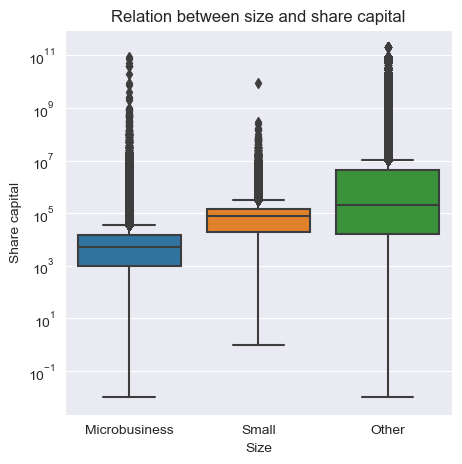

In [750]:
plot, ax = plt.subplots(figsize=(5, 5))
ax.set_yscale("log")

sns.boxplot(clean_data[clean_data['share_capital']>0],y='share_capital',x='company_size',order=['Microbusiness','Small','Other'])
ax.set_title("Relation between size and share capital")
ax.set_ylabel('Share capital')
ax.set_xlabel('Size');

To conclude this section we look into the email providers used to register the company

In [737]:
#use of hotmail/gmail small companies vs others
s=pd.Series(['others',(clean_data['email_provider'].value_counts()).iloc[3:].sum()],index=['index','Total'])

pd.DataFrame(clean_data['email_provider']
 .value_counts()
 .rename('Total')
 .reset_index()
 .sort_values(by='Total',ascending=False)
).iloc[:3].append(s,ignore_index=True)

C:\Users\rapha\AppData\Local\Temp\ipykernel_19076\90830594.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pd.DataFrame(clean_data['email_provider']


,index,Total
0,gmail,831795
1,hotmail,588121
2,yahoo,73157
3,others,535607


Most people use gmail (55.7%) followed by hotmail (39.4%) and yahoo (4.9%)

# Spatial distribution

Now, we will look into the spatial distribution of companies in PR state. Our first approach is to look at how many new companies are created in each town, note that the result needs to be carefully analyzed since the largest town will undoubtedly have more companies than the smallest one

In [738]:
all_muni=geobr.read_municipality(code_muni="PR", year=2007)
dic_char = {'Â':'A', 'Ó':'O', 'É':'E', 'Á':'A', 'Ú':'U', 'Ç':'C', 'Í':'I', 'Ã':'A', 'Ê':'E', 'Ô':'O'}
all_muni['name_muni']=all_muni['name_muni'].str.upper().replace(dic_char,regex=True)

In [739]:
all_muni=all_muni.merge((clean_data['town_name']
 .value_counts()
 .reset_index()
 .sort_values(by='index')
 .rename(columns={'index':'name_muni','town_name':'val_total'})),on='name_muni',how='left').fillna(1)

all_muni=all_muni.merge((clean_data[clean_data['economic_sector']=='Agriculture']['town_name']
 .value_counts()
 .reset_index()
 .sort_values(by='index')
 .rename(columns={'index':'name_muni','town_name':'val_agro'})),on='name_muni',how='left').fillna(1)

all_muni=(all_muni.merge((clean_data[clean_data['economic_sector']=='Industry']['town_name']
 .value_counts()
 .reset_index()
 .sort_values(by='index')
 .rename(columns={'index':'name_muni','town_name':'val_industria'})),on='name_muni',how='left')).fillna(1)

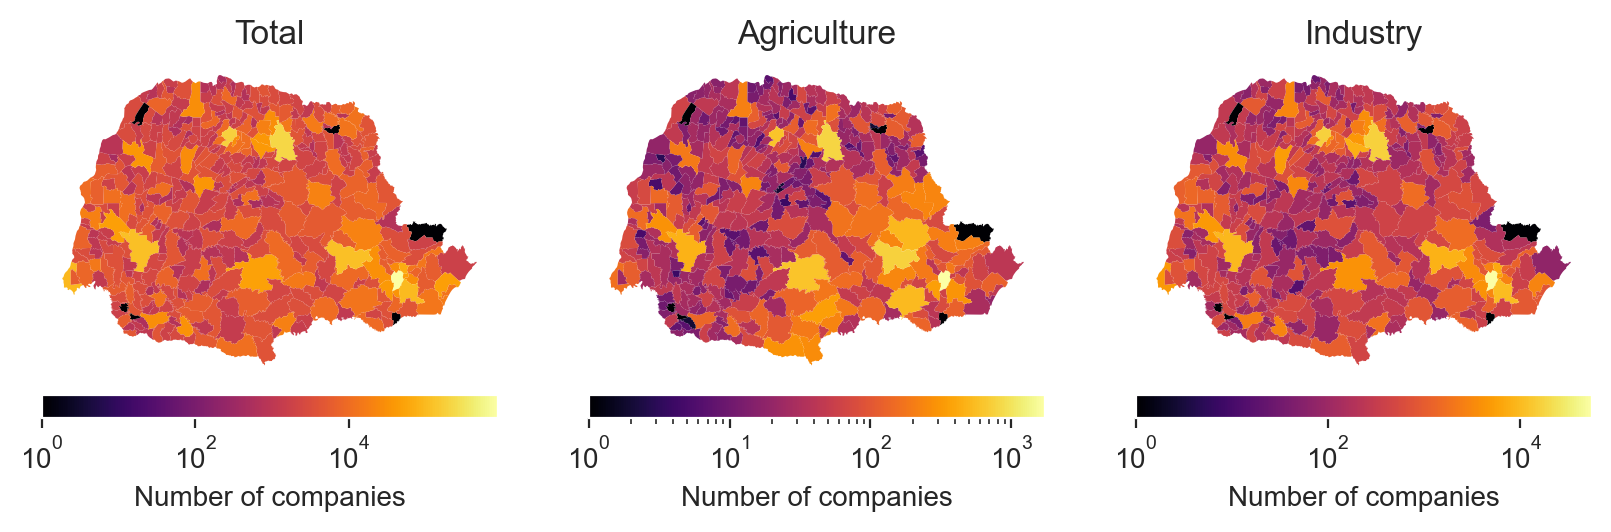

In [740]:
import matplotlib.colors as colors
fig, ax = plt.subplots(1,3,figsize=(10, 10), dpi=200)

all_muni.plot(column='val_total',cmap="inferno", ax=ax[0],legend=True,edgecolor='none',legend_kwds={'label': "Number of companies",'orientation': "horizontal","pad": 0.01}, norm=colors.LogNorm(vmin=all_muni.val_total.min(), vmax=all_muni.val_total.max()))

all_muni.plot(column='val_agro',cmap="inferno", ax=ax[1],legend=True,edgecolor='none',legend_kwds={'label': "Number of companies",'orientation': "horizontal","pad": 0.01}, norm=colors.LogNorm(vmin=all_muni.val_agro.min(), vmax=all_muni.val_agro.max()))

all_muni.plot(column='val_industria',cmap="inferno", ax=ax[2],legend=True,edgecolor='none',legend_kwds={'label': "Number of companies",'orientation': "horizontal", "pad": 0.01}, norm=colors.LogNorm(vmin=all_muni.val_industria.min(), vmax=all_muni.val_industria.max()))

for x,y in zip(['Total','Agriculture','Industry'],range(3)):
    ax[y].set_title(x)
    ax[y].axis("off")

In the figure above, we separated the map for the total amount of companies, and for the agriculture and industry sectors. Since the service sector comprises most of the total, the first plot works as a proxy for the service sector.  

To solve the issue of large cities having most the companies, we can plot the ratio between the proportion of companies in the city divided by the proportion of the population:
$$r = \frac{(\frac{N_{comp}}{T_{comp}})}{(\frac{N_{pop}}{T_{pop}})},$$
where $N_{comp}(N_{pop})$ is the number of created companies (population) in the city and $T_{comp}(T_{pop})$ is the total number of created companies (population) in PR state.
a $r>1$ means that proportionally, the city creates more companies than its population share.

In [742]:
#spatial distribution population%/number of companies% all_muni['val_total']/all_muni['val_total'].sum()
all_muni['code_muni']=all_muni['code_muni'].astype(int)
mun = pd.read_csv("full_data/municipio.csv") #Available at https://basedosdados.org/dataset/br-ibge-populacao?bdm_table=municipio
mun.rename(columns={'id_municipio':'code_muni'},inplace=True);
all_muni=all_muni.merge(mun[(mun['ano']==2021)&(mun['sigla_uf']=='PR')][['code_muni','populacao']],on='code_muni',how='left')

In [743]:
all_muni['pop_frac']=(all_muni['populacao']/all_muni['populacao'].sum())
all_muni['val_pop_ratio_total']=(all_muni['val_total']/all_muni['val_total'].sum())/all_muni['pop_frac']
all_muni['val_pop_ratio_agriculture']=(all_muni['val_agro']/all_muni['val_agro'].sum())/all_muni['pop_frac']
all_muni['val_pop_ratio_industry']=(all_muni['val_industria']/all_muni['val_industria'].sum())/all_muni['pop_frac']

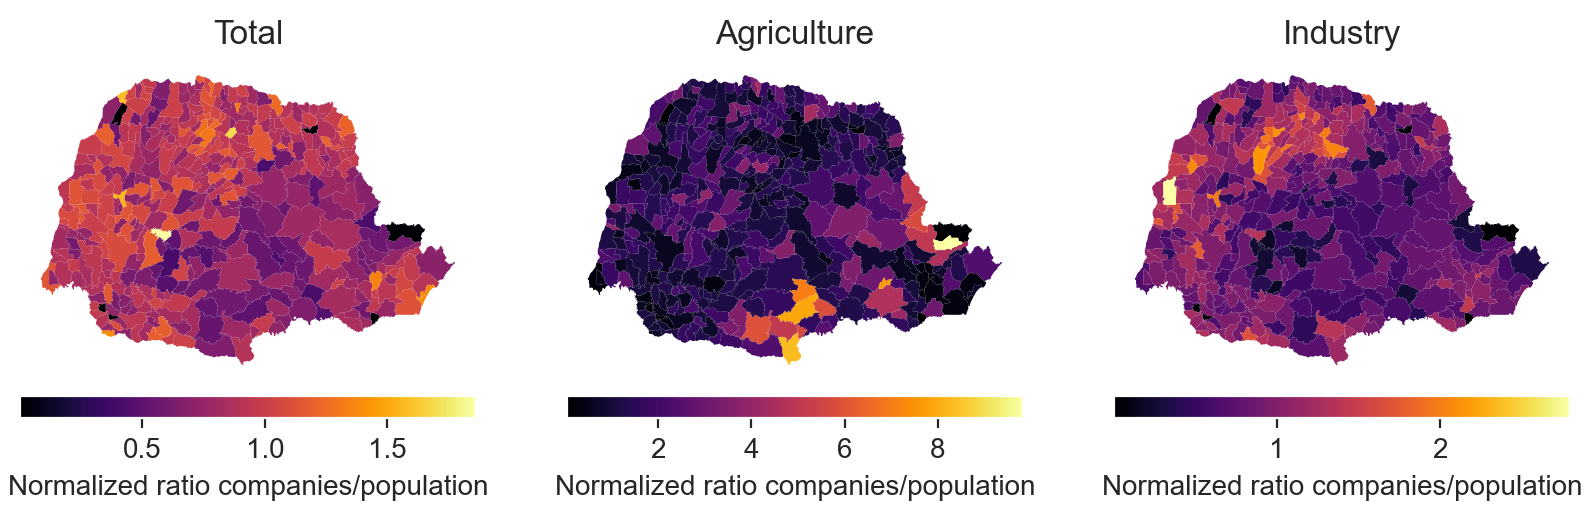

In [744]:
import matplotlib.colors as colors
fig, ax = plt.subplots(1,3,figsize=(10, 10), dpi=200)

all_muni.plot(column='val_pop_ratio_total',cmap="inferno", ax=ax[0],legend=True,edgecolor='none',legend_kwds={'label': "Normalized ratio companies/population",'orientation': "horizontal","pad": 0.01})

all_muni.plot(column='val_pop_ratio_agriculture',cmap="inferno", ax=ax[1],legend=True,edgecolor='none',legend_kwds={'label': "Normalized ratio companies/population",'orientation': "horizontal","pad": 0.01})

all_muni.plot(column='val_pop_ratio_industry',cmap="inferno", ax=ax[2],legend=True,edgecolor='none',legend_kwds={'label': "Normalized ratio companies/population",'orientation': "horizontal", "pad": 0.01})

for x,y in zip(['Total','Agriculture','Industry'],range(3)):
    ax[y].set_title(x)
    ax[y].axis("off")

# Modeling growth new companies

Now we will modell the growth of new companies using two distinct methods.
- Train a neural network to obtain a curve that fits our data
- Based on the general shape, we expect a region with polynomial growth and other region with exponential growth. We can fit these two curves to obtain our model.

In [478]:
data_model=(clean_data[(clean_data['company_start_year']>1969) & (clean_data['company_start_year']<2023)]['company_start_year']
.value_counts()
.rename('new_companies')
.reset_index()
.sort_values(by='index')
.to_numpy())

In [479]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
X_train, X_test, Y_train, Y_test = train_test_split(data_model[:,0],data_model[:,1],test_size=0.3)
Y_train= np.log(Y_train)
Y_test = np.log(Y_test)

In [480]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
X_train= x_scaler.fit_transform(np.reshape(X_train, (-1,1)))
X_test = x_scaler.transform(np.reshape(X_test, (-1,1)))
Y_train= y_scaler.fit_transform(np.reshape(Y_train, (-1,1)))
Y_test = y_scaler.transform(np.reshape(Y_test, (-1,1)))

In [481]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from keras.layers import LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping

In [492]:
model = Sequential()
model.add(Dense(100, input_shape=(1,),activation='relu'))
model.add(LeakyReLU(alpha=0.005))
model.add(Dense(100,activation='relu'))
model.add(LeakyReLU(alpha=0.03))
model.add(Dropout(0.2))
model.add(Dense(100,activation='relu'))
model.add(LeakyReLU(alpha=0.03))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

In [494]:
model.fit(x=X_train, 
          y=Y_train, 
          epochs=500,
          batch_size=22,
          validation_data=(X_test, Y_test), verbose=1
          )

Epoch 1/500
2/2 [==============================] - 1s 111ms/step - loss: 0.3258 - val_loss: 0.2725
Epoch 2/500
2/2 [==============================] - 0s 27ms/step - loss: 0.2451 - val_loss: 0.2008
Epoch 3/500
2/2 [==============================] - 0s 65ms/step - loss: 0.1827 - val_loss: 0.1342
Epoch 4/500
2/2 [==============================] - 0s 35ms/step - loss: 0.1267 - val_loss: 0.0770
Epoch 5/500
2/2 [==============================] - 0s 25ms/step - loss: 0.0780 - val_loss: 0.0338
Epoch 6/500
2/2 [==============================] - 0s 27ms/step - loss: 0.0359 - val_loss: 0.0085
Epoch 7/500
2/2 [==============================] - 0s 27ms/step - loss: 0.0249 - val_loss: 0.0032
Epoch 8/500
2/2 [==============================] - 0s 27ms/step - loss: 0.0100 - val_loss: 0.0135
Epoch 9/500
2/2 [==============================] - 0s 30ms/step - loss: 0.0260 - val_loss: 0.0247
Epoch 10/500
2/2 [==============================] - 0s 27ms/step - loss: 0.0381 - val_loss: 0.0254
Epoch 11/500
2/2 [

In [495]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot: >

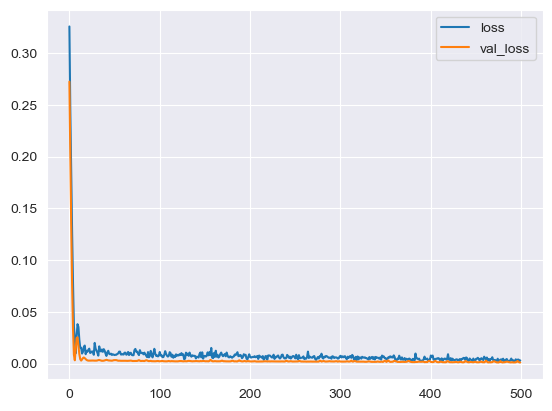

In [496]:
losses.plot()

In [497]:
xvals = np.linspace(data_model[0,0], data_model[-1,0]+20, 100)
predictions = model.predict(x_scaler.transform(np.reshape(xvals,(-1,1))))
predictions = y_scaler.inverse_transform(predictions)

4/4 [==============================] - 0s 1ms/step


In [498]:
from scipy.optimize import curve_fit

popt, pcov = curve_fit(lambda t, a, b, c: a*t**2 + b*t+c, data_model[:38,0], data_model[:38,1])
popt2, pcov2 = curve_fit(lambda t, a, b: a*t + b, data_model[38:,0], np.log(data_model[38:,1]))

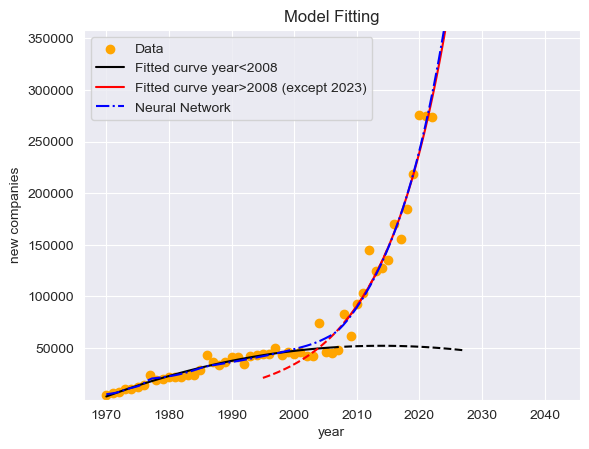

In [499]:
a,b,c = popt
a2,b2 = popt2

x_fitted = np.linspace(np.min(data_model[:38,0]), np.max(data_model[:38,0]), 100)
y_fitted = a*x_fitted**2 + b*x_fitted +c

x_fitted2 = np.linspace(np.min(data_model[38:,0]), np.max(data_model[38:,0])+5, 100)
y_fitted2 = np.exp(a2*x_fitted2 + b2)


x_fitted_dashed = np.linspace(np.min(data_model[38:,0]), np.max(data_model[45:,0])+5, 100)
y_fitted_dashed = a*x_fitted_dashed**2 + b*x_fitted_dashed +c

x_fitted2_dashed = np.linspace(np.min(data_model[25:46,0]), np.max(data_model[25:46,0]), 100)
y_fitted2_dashed = np.exp(a2*x_fitted2_dashed + b2)

ax = plt.axes()
ax.scatter(x= data_model[:,0], y = data_model[:,1], label='Data',color='orange')
ax.plot(x_fitted, y_fitted, 'k', label='Fitted curve year<2008')
ax.plot(x_fitted2, y_fitted2, 'r', label='Fitted curve year>2008 (except 2023)')

ax.plot(x_fitted_dashed, y_fitted_dashed, 'k--')
ax.plot(x_fitted2_dashed, y_fitted2_dashed, 'r--')

ax.plot(np.linspace(data_model[0,0], data_model[-1,0]+20, 100),np.exp(predictions),'b-.', label='Neural Network' )
ax.set_title(r'Model Fitting')
ax.set_ylabel('new companies')
ax.set_ylim(5, 1.3*max(data_model[:,1]))
ax.set_xlabel('year')
ax.legend()

The blue dotted-dashed line uses machine learning while the black and red line uses curve_fit to fit different regions (the dashed line shows beyond the fitting region). Interestingly enough both models agree nicely except in the transition region between polynomial/exponential growth, which has its unique dynamics. With this, we can conclude that our assumption of polynomial/exponential regions is indeed correct and can be used to predict the number of new companies in the PR state, at least for a short period in which the growth dynamic remains the same

# Predicting company size

We can play around a little more and try to classify the company size based on the information below. Note that the data below is not enough to cleanly separate Microbusinesses, Small and Other companies. Another potential issue is that share_capital is self-declared and doesn't need to correspond to reality.

In [608]:
clean_data[['town_name','economic_sector','entity_type','share_capital','headquarters','branches_state','company_size']].head()

,town_name,economic_sector,entity_type,share_capital,headquarters,branches_state,company_size
0,CURITIBA,Service,Empresário Individual,100.0,1,1,Microbusiness
1,CURITIBA,Industry,Empresário Individual,2000.0,1,1,Microbusiness
2,MARINGA,Service,Other,10000.0,1,1,Other
3,PARANAVAI,Industry,Empresário Individual,1000.0,1,1,Microbusiness
4,PINHAIS,Service,Empresário Individual,1.0,1,1,Microbusiness


In [675]:
pred_data = clean_data[['base_cnpj','town_name','economic_sector','entity_type','share_capital','headquarters','company_size']].drop_duplicates(subset='base_cnpj', keep="first")
pred_data = pred_data.merge(all_muni[['name_muni','populacao']],how='left',left_on='town_name',right_on='name_muni')
pred_data = pred_data.drop(['base_cnpj','town_name','name_muni'],axis=1)
dic_inverse = {'Microbusiness':0,  'Small':1,'Other':2}
pred_data['company_size'] = pred_data['company_size'].map(dic_inverse)
pred_data = pd.get_dummies(pred_data,drop_first=True,columns=['economic_sector','entity_type']).dropna()

In [576]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [677]:
X = pred_data.drop('company_size',axis=1).values
Y = pred_data['company_size'].values

In [586]:
from tensorflow.keras.utils import to_categorical

In [678]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.25)
Y_train = to_categorical(Y_train, num_classes=3)
Y_test = to_categorical(Y_test, num_classes=3)

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [679]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from keras.layers import LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping

In [692]:
model = Sequential()
model.add(Dense(9, input_dim = X_train.shape[1], activation = 'relu'))
model.add(Dense(6, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(6, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))
model.compile(loss="categorical_crossentropy", optimizer= "adam", metrics=['accuracy'])

In [693]:
model.fit(x=X_train, 
          y=Y_train, 
          epochs=15,
          batch_size=10000,
          validation_data=(X_test, Y_test), verbose=1
          )

Epoch 1/15
269/269 [==============================] - 3s 7ms/step - loss: 0.9960 - accuracy: 0.7167 - val_loss: 0.8338 - val_accuracy: 0.8267
Epoch 2/15
269/269 [==============================] - 2s 7ms/step - loss: 0.7815 - accuracy: 0.8167 - val_loss: 0.7008 - val_accuracy: 0.8271
Epoch 3/15
269/269 [==============================] - 2s 7ms/step - loss: 0.6844 - accuracy: 0.8169 - val_loss: 0.6255 - val_accuracy: 0.8272
Epoch 4/15
269/269 [==============================] - 2s 7ms/step - loss: 0.6054 - accuracy: 0.8167 - val_loss: 0.5180 - val_accuracy: 0.8272
Epoch 5/15
269/269 [==============================] - 2s 7ms/step - loss: 0.5465 - accuracy: 0.8166 - val_loss: 0.4907 - val_accuracy: 0.8272
Epoch 6/15
269/269 [==============================] - 2s 7ms/step - loss: 0.5327 - accuracy: 0.8191 - val_loss: 0.4845 - val_accuracy: 0.8272
Epoch 7/15
269/269 [==============================] - 2s 8ms/step - loss: 0.5199 - accuracy: 0.8195 - val_loss: 0.4781 - val_accuracy: 0.8272
Epoch 

<AxesSubplot: >

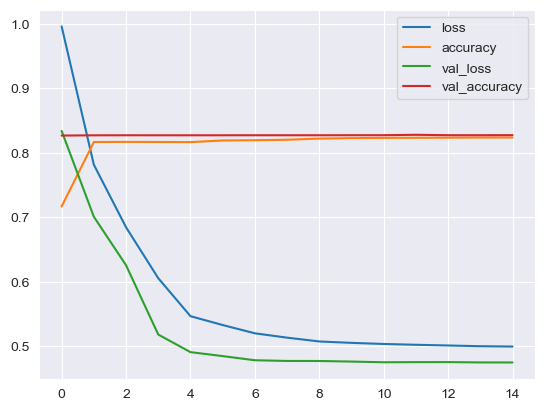

In [694]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

In [695]:
from sklearn.metrics import classification_report,confusion_matrix

In [696]:
predictions = model.predict(X_test)
print(classification_report(Y_test,np.round(predictions)))

27930/27930 [==============================] - 20s 723us/step


c:\Users\rapha\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.82      0.99      0.90    658825
           1       0.00      0.00      0.00     20137
           2       0.96      0.39      0.55    214787

   micro avg       0.83      0.82      0.83    893749
   macro avg       0.59      0.46      0.48    893749
weighted avg       0.83      0.82      0.79    893749
 samples avg       0.82      0.82      0.82    893749



c:\Users\rapha\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [697]:
print(confusion_matrix(Y_test.argmax(axis=1), np.round(predictions).argmax(axis=1)))

[[655625      0   3200]
 [ 19672      0    465]
 [131043      0  83744]]


The model classifies well microbusinesses, but it completely fails the small ones. The reason for this is that all Microbusinesses are of the legal type ("Empresario individual") which some (but not all!) small businesses also are. Another issue is the oversimplification in the legal type and economic sectors that might play a role. This suggests that a simple classifiers (is it microbusiness?) should perform better, although not perfect